In [1]:
import librosa
import librosa.display
import os
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.spatial.distance import cosine
from scipy.spatial.distance import euclidean

In [2]:
def sim_matrix(spectrogram):
    num_frames = spectrogram.shape[0]
#     print("Number of frames: " + str(num_frames))
    S = np.ndarray(shape=(num_frames, num_frames))
    for i in range(num_frames):
        for j in range(num_frames):
            S[i, j] = 1 - cosine(spectrogram[i], spectrogram[j])
    return S

In [3]:
def beat_spectrum(y, sr, S):
    # beat_spectrum = np.correlate(S[0], S[0], mode='full')
    # beat_spectrum = beat_spectrum[:len(beat_spectrum) // 2]
    duration = librosa.core.get_duration(y, sr)
    frames_per_sec = S.shape[0] / duration
    lag_range = duration
    num_frames = int(lag_range * frames_per_sec) - 1
#     print(num_frames)
    bs = []
    for l in range(num_frames):
        sum = np.sum([S[i, i + l] for i in range(len(S) - num_frames)])
#         sum /= (len(S) - num_frames)
        bs.append(sum)
#     mean = np.mean(bs)
#     bs -= mean
    return bs

In [4]:
def robust_beat_spectrum(y, sr, S):
    duration = librosa.core.get_duration(y, sr)
    frames_per_sec = S.shape[0] / duration
    lag_range = duration
    num_frames = int(lag_range * frames_per_sec) - 1
    bs = []
    print(num_frames)
    for l in range(num_frames):
        sum = 0
        for i in range(num_frames):
            for j in range(num_frames - l):
                sum += S[i][j] * S[i][j + l]
        print(sum)
        bs.append(sum)
    return bs

In [5]:
def plot_spectrogram(spectrogram):
    plt.figure(figsize=(10, 4))
    S_dB = librosa.power_to_db(spectrogram, ref=np.max)
    librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram')
    plt.tight_layout()
    plt.show()

In [6]:
class SongEntry:
    def __init__(self, y, sr, id):
        self.y = y
        self.sr = sr
        self.id = id
        self.init_beat_spectrum()

    def init_beat_spectrum(self):
        spectrogram = librosa.feature.melspectrogram(y=self.y, sr=self.sr, n_mels=128)
        S = sim_matrix(spectrogram)
        bs = beat_spectrum(y=self.y, sr=self.sr, S=S)
        self.bs = bs
    
    def cos_sim(self, songEntry):
        return 1 - cosine(self.bs, songEntry.bs)

In [7]:
def retrieveNearestK(query, db, k):
    sims = list()
    for entry in db:
        sim = query.cos_sim(entry)
        sims.append((entry.id, sim))
    sims.sort(key=lambda tup: tup[1], reverse=True)
    neighbors = list()
    for i in range(k):
        neighbors.append(sims[i][0])
    return neighbors        

In [8]:
def evaluate(db, queries, k): #lists of SongEntry's
    num_correct = 0
    time_sum = 0
    for query in queries:
        start = time.time()
        nearestK = retrieveNearestK(query=query, db=db, k=k)
        end = time.time()
        time_sum += (end - start)
        for id in nearestK:
            if (id == query.id):
                num_correct += 1
#             else:
#                 print('query id: ' + str(query.id) + ', db id: ' + str(id))
    total = len(queries) * k
    accuracy = num_correct / total
    avg_time_elapsed = time_sum / len(queries)
    return accuracy, avg_time_elapsed

In [9]:
data_dir = os.path.join(os.getcwd(), '..\\..\\data\\')
data_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir)]
songDB = []
queries = []
songs_per_query = 2
initial_offset = 5
for j, data_file in enumerate(data_files):
    print('loading song ' + str(j) + ' of ' + str(len(data_files)))
    y, sr = librosa.load(data_file, duration=10, offset=initial_offset)
    a = SongEntry(y, sr, data_file)
    queries.append(a)
    for i in range(1, 1 + songs_per_query):
        y, sr = librosa.load(data_file, duration=10, offset=initial_offset+i*10)
        a = SongEntry(y, sr, data_file)
        songDB.append(a)
print(str(len(queries)) + ' query samples and ' + str(len(songDB)) + ' DB samples saved')

loading song 0 of 15
loading song 1 of 15
loading song 2 of 15
loading song 3 of 15
loading song 4 of 15
loading song 5 of 15
loading song 6 of 15
loading song 7 of 15
loading song 8 of 15
loading song 9 of 15
loading song 10 of 15
loading song 11 of 15
loading song 12 of 15
loading song 13 of 15
loading song 14 of 15
15 query samples and 30 DB samples saved


In [10]:
accuracy, avg_time_elapsed = evaluate(db=songDB, queries=queries, k=songs_per_query)
print('Accuracy: ' + str(accuracy) + ', Average Time Elapsed: ' + str(avg_time_elapsed))

Accuracy: 0.8333333333333334, Average Time Elapsed: 0.0036569754282633465


C:\Users\Andrew\Desktop\COEN\281\Final Project\RhythmSearch\notebooks\..\..\data\bensound-allthat.wav


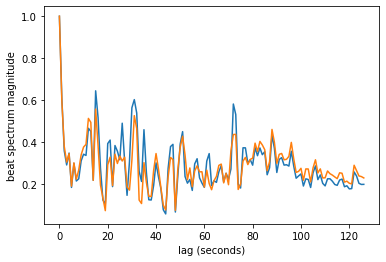

In [11]:
spectrogram = librosa.feature.melspectrogram(y=queries[0].y, sr=queries[0].sr, n_mels=256)
S = sim_matrix(spectrogram)
# bs = beat_spectrum(y=queries[0].y, sr=queries[0].sr, S=S)
print(queries[0].id)
plt.xlabel('lag (seconds)')
plt.ylabel('beat spectrum magnitude')
plt.plot(queries[0].bs)
plt.plot(songDB[0].bs)

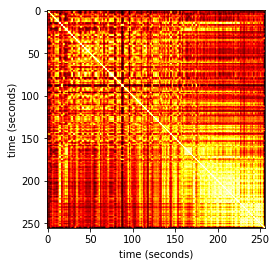

In [12]:
S  /= (S.shape[0] / 10)
plt.imshow(S, cmap='hot', interpolation='nearest')
plt.xlabel('time (seconds)')
plt.ylabel('time (seconds)')
plt.show()

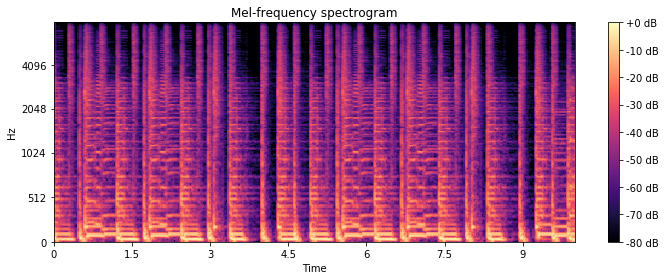

In [13]:
# spectrogram = librosa.feature.melspectrogram(y=queries[0].y, sr=queries[0].sr, n_mels=256)
# S = sim_matrix(spectrogram)
# bs = beat_spectrum(y=queries[0].y, sr=queries[0].sr, S=S)
plot_spectrogram(spectrogram)
# print(queries[2].id)
# plt.plot(queries[2].bs)
# plt.plot(songDB[10].bs)

In [14]:
from lshash import LSHash
import random

In [15]:
def LSHSetup(db, songs_per_query, num_bit):
    songDB = []
    queries = []
    hash = LSHash(num_bit,127)

    for song in db:
        hash.index(song) #Adds to LSH hashtable
    
    print("All Keys in Hashtable")    
    print(list(hash.hash_tables[0].storage.keys()))
    return hash

In [19]:
def evaluateLSH(db, queries, hash, k):
    num_correct = 0
    time_sum = 0
    for q in queries:
        start = time.clock()
        result = hash.query(q)
        end = time.clock()
        time_sum += end - start
        for output in result:
            if (output[0] == q.id):
                num_correct += 1
            #else:
                #print('query id: ' + str(query.id) + ', db id: ' + str(output[0]))
    total = len(queries) * k
    accuracy = num_correct / total
    avg_time_elapsed = time_sum / len(queries)
    return accuracy, avg_time_elapsed

In [21]:
N = 10 # Number of Iterations
total_accuracy = 0
total_time = 0

for i in range(N):
    print("SETTING UP HASHTABLE")
    hash = LSHSetup(songDB, songs_per_query=2, num_bit=3) # 3 bit binary hash
    print("EVALUATING")
    accuracy, avg_time_elapsed = evaluateLSH(db=songDB, queries=queries, hash=hash, k=2)
    total_accuracy += accuracy
    total_time += avg_time_elapsed
    print('Accuracy: ' + str(accuracy) + ', Average Time Elapsed: ' + str(avg_time_elapsed))
    
print("FINAL RESULTS")
print('Average Accuracy over ' + str(N) + ' iterations: ' + str(total_accuracy/N))
print('Average Time Elapsed over ' + str(N) + ' iterations: ' + str(total_time/N))

SETTING UP HASHTABLE
All Keys in Hashtable
['1011', '0011', '1001']
EVALUATING
Accuracy: 0.8, Average Time Elapsed: 0.0014058333333309748
SETTING UP HASHTABLE
All Keys in Hashtable
['0011', '0111', '0001', '1001', '0101', '1011', '1010', '0110']
EVALUATING
No Similar Candidates


NameError: name 'hamming_binary' is not defined